# Monte Carlo Dropout and Deep Ensemble for Bayesian Deep Learning

References

1. https://cs231n.github.io/neural-networks-2/#reg
2. https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/DL2/Bayesian_Neural_Networks/dl2_bnn_tut2_student_with_answers.html
3. https://docs.aws.amazon.com/prescriptive-guidance/latest/ml-quantifying-uncertainty/mc-dropout.html
4. https://docs.aws.amazon.com/prescriptive-guidance/latest/ml-quantifying-uncertainty/deep-ensembles.html
5. https://nipunbatra.github.io/papers/2022/buildsys22-nilm.pdf

![](../diagrams/nn-archs.png)

## Imports

In [1]:
### Regular Dropout

import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd

import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [2]:
from tueplots import bundles
plt.rcParams.update(bundles.beamer_moml())


# Also add despine to the bundle using rcParams
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Increase font size to match Beamer template
plt.rcParams['font.size'] = 16
# Make background transparent
plt.rcParams['figure.facecolor'] = 'none'

Inspired from: https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/DL2/Bayesian_Neural_Networks/dl2_bnn_tut2_student_with_answers.html

In [3]:
def get_simple_data_train():
    x = torch.linspace(-2, 4, 300)
    x = torch.hstack([x, torch.linspace(6, 8, 300)])
    f = lambda x: torch.sin(x)
    eps = torch.randn_like(x) * 0.1
    f_x = f(x) 
    y_train = f_x + eps
    x_train = x[:, None]
    return x_train, y_train, f

In [4]:
def plot_generic(add_to_plot=None):
    fig, ax = plt.subplots()

    plt.xlabel("X",)
    plt.ylabel("Y",)

    x_train, y_train, true_func = get_simple_data_train()
    
    x_all = torch.linspace(-2, 8, 1000)

    ax.plot(x_train, y_train, 'C0', marker='o', ms= 4, linestyle='none', alpha=0.2, label='Observations')
    ax.plot(x_all, true_func(x_all), 'C1', linewidth=1, label="true function")
    if add_to_plot is not None:
        add_to_plot(ax)

    plt.legend(loc=4, frameon=False)
    plt.show()

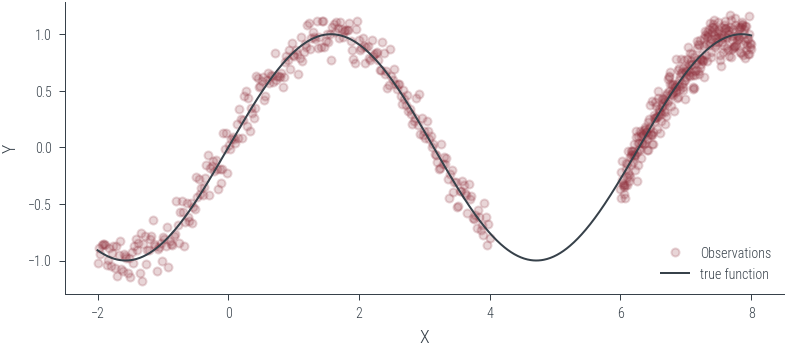

In [5]:
plot_generic()

In [6]:
# Define a simple MLP without using nn.Linear

input_dim = 1

hidden_l1_dim = 100
hidden_l2_dim = 50


def init_params():
    W1 = nn.Parameter(torch.randn(input_dim, hidden_l1_dim, requires_grad=True).to(device))
    b1 = nn.Parameter(torch.zeros(hidden_l1_dim, requires_grad=True).to(device))
    W2 = nn.Parameter(torch.randn(hidden_l1_dim, hidden_l2_dim, requires_grad=True).to(device))
    b2 = nn.Parameter(torch.zeros(hidden_l2_dim, requires_grad=True).to(device))
    W3 = nn.Parameter(torch.randn(hidden_l2_dim, 1, requires_grad=True).to(device))
    b3 = nn.Parameter(torch.zeros(1, requires_grad=True).to(device))
    return [W1, b1, W2, b2, W3, b3]


def mlp(x, params, p=0.0):
    W1, b1, W2, b2, W3, b3 = params
    h1 = torch.tanh(x @ W1 + b1)
    h2 = torch.tanh(h1 @ W2 + b2)
    return (h2 @ W3 + b3).ravel()

In [7]:
train_x, train_y, true_func = get_simple_data_train()
train_x = train_x.to(device)
train_y = train_y.to(device)


In [8]:
train_x.shape

torch.Size([600, 1])

In [9]:
test_x = torch.linspace(-2, 8, 1000)[:, None]
test_x = test_x.to(device)

In [10]:
parameters = init_params()


with torch.no_grad():
    y_hat_untrained = mlp(test_x, parameters).ravel()
# Detach and convert to numpy
y_hat_untrained = y_hat_untrained.cpu().detach().numpy()

In [11]:
def plot_predictions(x_test, y_preds):
    def add_predictions(ax):
        ax.plot(x_test, y_preds, 'C2', label='neural net prediction')

    plot_generic(add_predictions)


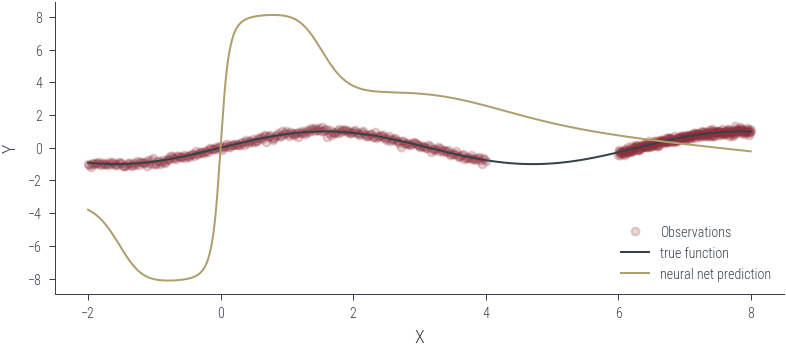

In [12]:
# Plot the untrained model
plot_predictions(test_x.cpu(), y_hat_untrained)

## Simple MLP

In [13]:
# Modify the train function to pass the dropout flag and dropout probability
def train(params, opt, fwd_func, x_train, y_train, epochs=1000, dropout=False, p=0.0):
    for i in range(epochs):
        y_hat = fwd_func(x_train, params, p)  # Pass the dropout flag and probability to fwd_func
        loss = F.mse_loss(y_hat, y_train)
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        if i % 300 == 0:
            print(f"Epoch {i}, loss {loss.item():.3f}")
    return params

In [14]:
parameters = init_params()

# Continue with optimizer
optimizer = torch.optim.Adam(parameters, lr=3e-4)

trained_params = train(parameters, optimizer, mlp, train_x, train_y, epochs=6000, dropout=False, p=0.0)

Epoch 0, loss 20.761
Epoch 300, loss 0.040
Epoch 600, loss 0.015
Epoch 900, loss 0.013
Epoch 1200, loss 0.012
Epoch 1500, loss 0.012
Epoch 1800, loss 0.012
Epoch 2100, loss 0.011
Epoch 2400, loss 0.011
Epoch 2700, loss 0.011
Epoch 3000, loss 0.011
Epoch 3300, loss 0.011
Epoch 3600, loss 0.011
Epoch 3900, loss 0.011
Epoch 4200, loss 0.010
Epoch 4500, loss 0.010
Epoch 4800, loss 0.010
Epoch 5100, loss 0.010
Epoch 5400, loss 0.010
Epoch 5700, loss 0.010


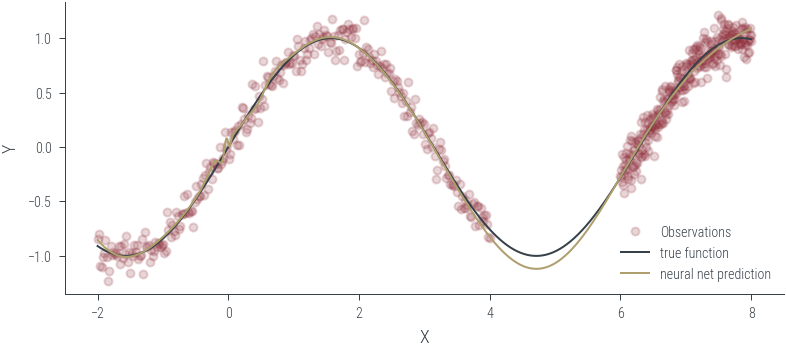

In [15]:
# Plot the trained model
with torch.no_grad():
    y_hat_trained = mlp(test_x, trained_params).ravel()
# Detach and convert to numpy
y_hat_trained = y_hat_trained.cpu().detach().numpy()

plot_predictions(test_x.cpu(), y_hat_trained)

## Deep ensemble

In [16]:
# Define a simple MLP without using nn.Linear

input_dim = 1

hidden_l1_dim = 100
hidden_l2_dim = 50


def init_params():
    W1 = nn.Parameter(torch.randn(input_dim, hidden_l1_dim, requires_grad=True).to(device))
    b1 = nn.Parameter(torch.zeros(hidden_l1_dim, requires_grad=True).to(device))
    W2 = nn.Parameter(torch.randn(hidden_l1_dim, hidden_l2_dim, requires_grad=True).to(device))
    b2 = nn.Parameter(torch.zeros(hidden_l2_dim, requires_grad=True).to(device))
    W3 = nn.Parameter(torch.randn(hidden_l2_dim, 1, requires_grad=True).to(device))
    b3 = nn.Parameter(torch.zeros(1, requires_grad=True).to(device))
    return [W1, b1, W2, b2, W3, b3]


def mlp(x, params, p=0.0):
    W1, b1, W2, b2, W3, b3 = params
    h1 = torch.tanh(x @ W1 + b1)
    h2 = torch.tanh(h1 @ W2 + b2)
    return (h2 @ W3 + b3).ravel()

In [17]:
n_ensembles = 5

ensemble_params_list = []
for i in range(n_ensembles):
    print(f"Training ensemble member {i}")
    parameters = init_params()
    optimizer = torch.optim.Adam(parameters, lr=3e-4)
    trained_params = train(parameters, optimizer, mlp, train_x, train_y, epochs=6000, dropout=False, p=0.0)
    ensemble_params_list.append(trained_params)

Training ensemble member 0
Epoch 0, loss 3.468
Epoch 300, loss 0.038
Epoch 600, loss 0.020
Epoch 900, loss 0.014
Epoch 1200, loss 0.012
Epoch 1500, loss 0.011
Epoch 1800, loss 0.011
Epoch 2100, loss 0.010
Epoch 2400, loss 0.010
Epoch 2700, loss 0.010
Epoch 3000, loss 0.010
Epoch 3300, loss 0.010
Epoch 3600, loss 0.010
Epoch 3900, loss 0.010
Epoch 4200, loss 0.010
Epoch 4500, loss 0.010
Epoch 4800, loss 0.010
Epoch 5100, loss 0.010
Epoch 5400, loss 0.009
Epoch 5700, loss 0.009
Training ensemble member 1
Epoch 0, loss 34.524
Epoch 300, loss 0.042
Epoch 600, loss 0.022
Epoch 900, loss 0.015
Epoch 1200, loss 0.014
Epoch 1500, loss 0.013
Epoch 1800, loss 0.013
Epoch 2100, loss 0.013
Epoch 2400, loss 0.013
Epoch 2700, loss 0.012
Epoch 3000, loss 0.012
Epoch 3300, loss 0.012
Epoch 3600, loss 0.012
Epoch 3900, loss 0.012
Epoch 4200, loss 0.012
Epoch 4500, loss 0.012
Epoch 4800, loss 0.012
Epoch 5100, loss 0.011
Epoch 5400, loss 0.011
Epoch 5700, loss 0.011
Training ensemble member 2
Epoch 0, l

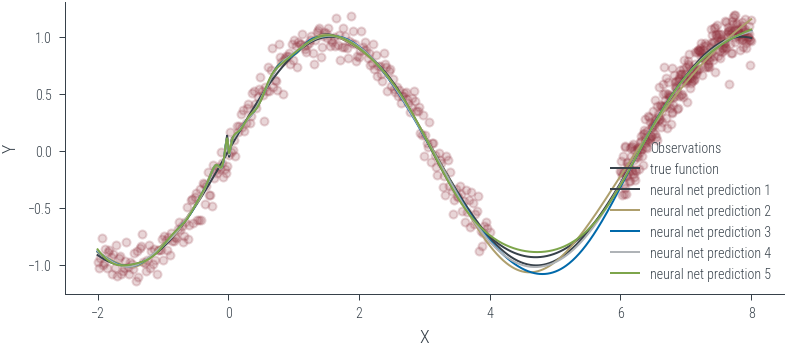

In [18]:
# Plot the trained model
def plot_deep_ensemble(x_test, y_preds_list):
    def add_predictions(ax):
        for i, y_preds in enumerate(y_preds_list, 1):
            ax.plot(x_test, y_preds, f'C{i}', label=f'neural net prediction {i}')

    plot_generic(add_predictions)

y_preds_list = []
for trained_params in ensemble_params_list:
    with torch.no_grad():
        y_hat_trained = mlp(test_x, trained_params)
        y_hat_trained = y_hat_trained.cpu().numpy()
        y_preds_list.append(y_hat_trained)
        
plot_deep_ensemble(test_x.cpu(), y_preds_list)

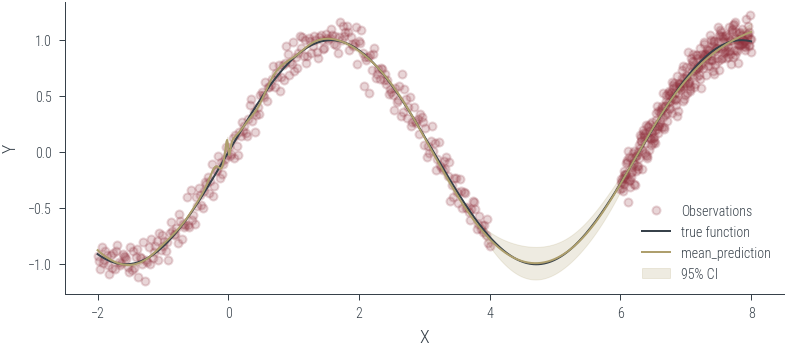

In [19]:
def plot_deep_ensemble_uncertainty(x_test, y_preds_list):
    def add_predictions(ax):
        y_mean = np.array(y_preds_list).mean(axis=0)
        y_std = np.array(y_preds_list).std(axis=0)
        ax.plot(x_test, y_mean, f'C2', label=f'mean_prediction')
        ax.fill_between(x_test.ravel(), y_mean - 2*y_std, y_mean + 2*y_std, alpha=0.2, color='C2', label='95% CI')

    plot_generic(add_predictions)
    
plot_deep_ensemble_uncertainty(test_x.cpu(), y_preds_list)

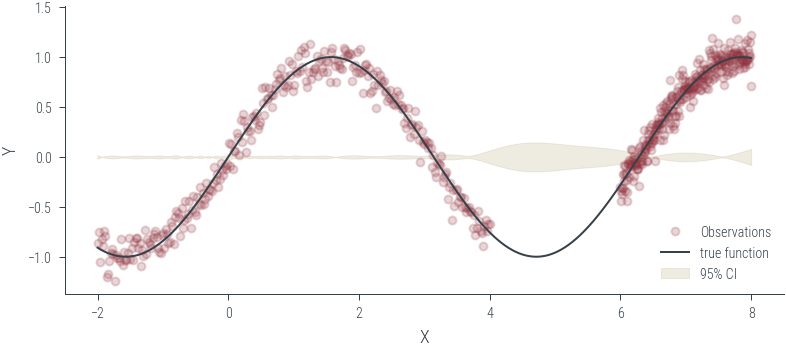

In [20]:
def plot_just_uncertainty_deep_ensemble(x_test, y_preds_list):
    def add_predictions(ax):
        y_std = np.array(y_preds_list).std(axis=0)
        ax.fill_between(x_test.ravel(), -2*y_std, 2*y_std, alpha=0.2, color='C2', label='95% CI')

    plot_generic(add_predictions)
    
plot_just_uncertainty_deep_ensemble(test_x.cpu(), y_preds_list)

## Dropout from scratch

![](https://i.ytimg.com/vi/D8PJAL-MZv8/hqdefault.jpg)

In [36]:
### Now adding dropout to the model by manually masking the activations
W1, b1, W2, b2, W3, b3 = parameters
h1 = torch.tanh(test_x @ W1 + b1)
h1.shape


torch.Size([1000, 100])

In [37]:
# probability of dropping out each neuron
p = 0.2

In [38]:
mask = torch.rand_like(h1) > p
mask.shape

torch.Size([1000, 100])

In [39]:
h1.shape

torch.Size([1000, 100])

In [40]:
mask.sum()

tensor(79933, device='cuda:0')

In [41]:
mask.numel()

100000

In [48]:
masked_activations = (h1 * mask)/(1-p)
masked_activations.shape

torch.Size([1000, 100])

In [49]:
m = nn.Dropout(p=0.2)
out_h = m(h1)

In [55]:
pd.DataFrame(out_h.cpu().detach().numpy()).head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.280216,-0.000000,-0.372197,-0.000000,0.000000,0.346530,0.000000,-0.000000,-0.000000,1.226020,...,-0.667853,0.510881,1.116930,-1.071659,0.000000,-1.239488,0.782513,-0.000000,-1.115131,0.299465
1,0.278635,-1.232603,-0.370602,-1.182943,1.102740,0.000000,1.181993,-0.631225,-0.738800,1.225449,...,-0.665564,0.508894,0.000000,-1.069398,0.000000,-1.239203,0.779832,-0.965390,-1.113328,0.298324
2,0.277052,-0.000000,-0.369005,-1.181741,0.000000,0.343636,1.180778,-0.628681,-0.735845,1.224865,...,-0.663269,0.506903,1.113202,-1.067112,1.168637,-0.000000,0.777140,-0.962910,-1.111502,0.000000
3,0.275469,-1.231721,-0.367408,-1.180517,1.098915,0.000000,1.179542,-0.626130,-0.732877,1.224268,...,-0.000000,0.504909,1.111301,-0.000000,1.167272,-1.238610,0.000000,-0.960412,-1.109653,0.296039
4,0.273885,-1.231263,-0.000000,-1.179272,1.096968,0.340738,1.178285,-0.623572,-0.729897,1.223656,...,-0.658661,0.000000,1.109375,-1.062458,1.165885,-0.000000,0.771719,-0.957894,-1.107781,0.294896


In [56]:
pd.DataFrame(h1.cpu().detach().numpy()/(1-p)).head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.280216,-1.233028,-0.372197,-1.184125,1.104618,0.346530,1.183187,-0.633762,-0.741743,1.226020,...,-0.667853,0.510881,1.116930,-1.071659,1.171302,-1.239488,0.782513,-0.967852,-1.115131,0.299465
1,0.278635,-1.232603,-0.370602,-1.182943,1.102740,0.345083,1.181993,-0.631225,-0.738800,1.225449,...,-0.665564,0.508894,1.115078,-1.069398,1.169980,-1.239203,0.779832,-0.965390,-1.113328,0.298324
2,0.277052,-1.232167,-0.369005,-1.181740,1.100839,0.343636,1.180778,-0.628681,-0.735845,1.224865,...,-0.663269,0.506903,1.113202,-1.067111,1.168637,-1.238910,0.777139,-0.962910,-1.111502,0.297182
3,0.275469,-1.231721,-0.367408,-1.180517,1.098915,0.342187,1.179542,-0.626130,-0.732877,1.224268,...,-0.660968,0.504909,1.111301,-1.064798,1.167272,-1.238610,0.774435,-0.960412,-1.109653,0.296039
4,0.273885,-1.231263,-0.365808,-1.179272,1.096968,0.340738,1.178285,-0.623572,-0.729897,1.223656,...,-0.658661,0.502913,1.109375,-1.062458,1.165885,-1.238301,0.771719,-0.957894,-1.107781,0.294896


In [46]:
pd.DataFrame(masked_activations.cpu().detach().numpy()).head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.224173,-0.986423,-0.297758,-0.947300,0.883695,0.277224,0.946549,-0.507009,-0.593395,0.980816,...,-0.000000,0.408705,0.000000,-0.857327,0.937041,-0.991591,0.626010,-0.000000,-0.892105,0.239572
1,0.222908,-0.000000,-0.296482,-0.946354,0.882192,0.276067,0.945594,-0.504980,-0.000000,0.980359,...,-0.000000,0.000000,0.000000,-0.000000,0.935984,-0.991363,0.623866,-0.000000,-0.890662,0.238659
2,0.221642,-0.000000,-0.000000,-0.000000,0.000000,0.274909,0.944622,-0.502945,-0.588676,0.979892,...,-0.530616,0.000000,0.890561,-0.853689,0.000000,-0.991128,0.621712,-0.000000,-0.889202,0.237745
3,0.220375,-0.985376,-0.293926,-0.944414,0.000000,0.273750,0.943634,-0.000000,-0.586302,0.979414,...,-0.528775,0.403928,0.000000,-0.851838,0.933818,-0.990888,0.619548,-0.768329,-0.887722,0.236831
4,0.000000,-0.985010,-0.292647,-0.000000,0.877574,0.272590,0.942628,-0.498858,-0.583917,0.978925,...,-0.526929,0.000000,0.000000,-0.849966,0.932708,-0.990641,0.617375,-0.000000,-0.886225,0.235917


In [61]:
mask_pytorch = h1!=out_h*(1-p)
mask_pytorch

tensor([[ True,  True, False,  ...,  True,  True,  True],
        [ True,  True, False,  ..., False, False, False],
        [False,  True, False,  ..., False, False,  True],
        ...,
        [False, False, False,  ...,  True, False, False],
        [ True, False, False,  ...,  True,  True, False],
        [ True, False,  True,  ...,  True, False,  True]], device='cuda:0')

In [30]:
pd.DataFrame(mask.cpu().detach().numpy()).head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,False,True,False,True,True,True,True,True,False,True,...,True,True,True,True,False,True,True,True,False,True
1,True,True,True,False,True,True,True,True,False,False,...,True,False,True,True,False,False,True,False,False,True
2,True,True,True,True,False,True,True,True,False,True,...,True,True,True,False,False,True,True,False,True,True
3,False,True,True,True,True,True,True,True,False,True,...,False,False,False,True,False,True,True,True,True,True
4,False,False,True,True,True,True,True,True,True,True,...,True,True,False,True,True,True,True,True,True,True


## MC-dropout

In [31]:
### Rewriting the model with dropout

def mlp_dropout(x, params, p=0.0, training=True):
    W1, b1, W2, b2, W3, b3 = params
    h1 = torch.tanh(x @ W1 + b1)
    #h2 = torch.sin(h1 @ W2 + b2)
    #h3 = h2 @ W3 + b3
    #return h3
    if training:
        # probability of dropping out each neuron
        mask = torch.rand_like(h1) > p
        h1 = h1 * mask
        # scale activations to account for dropout
        h1 = h1 / (1 - p)
    h2 = torch.tanh(h1 @ W2 + b2)
    if training:
        # probability of dropping out each neuron
        mask = torch.rand_like(h2) > p
        h2 = h2 * mask
        # scale activations to account for dropout
        h2 = h2 / (1 - p)
    h3 = h2 @ W3 + b3
    return h3.ravel()

In [32]:
# Train the model
p = 0.1
parameters = init_params()

# Continue with optimizer
optimizer = torch.optim.Adam(parameters, lr=3e-4)
trained_params = train(parameters, optimizer, mlp_dropout, train_x, train_y, epochs=10000, dropout=True, p=p)

Epoch 0, loss 44.786
Epoch 300, loss 9.598
Epoch 600, loss 7.986
Epoch 900, loss 6.820
Epoch 1200, loss 4.998
Epoch 1500, loss 5.564
Epoch 1800, loss 4.685
Epoch 2100, loss 4.184
Epoch 2400, loss 3.587
Epoch 2700, loss 3.388
Epoch 3000, loss 3.114
Epoch 3300, loss 2.926
Epoch 3600, loss 2.245
Epoch 3900, loss 2.271
Epoch 4200, loss 1.819
Epoch 4500, loss 1.889
Epoch 4800, loss 1.622
Epoch 5100, loss 1.395
Epoch 5400, loss 1.058
Epoch 5700, loss 0.993
Epoch 6000, loss 0.838
Epoch 6300, loss 0.794
Epoch 6600, loss 0.623
Epoch 6900, loss 0.541
Epoch 7200, loss 0.531
Epoch 7500, loss 0.395
Epoch 7800, loss 0.387
Epoch 8100, loss 0.318
Epoch 8400, loss 0.274
Epoch 8700, loss 0.270
Epoch 9000, loss 0.222
Epoch 9300, loss 0.223
Epoch 9600, loss 0.210
Epoch 9900, loss 0.194


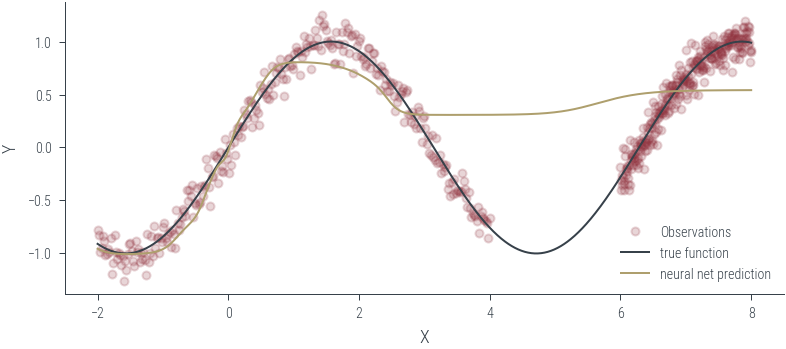

In [33]:
# Predictions with dropout
with torch.no_grad():
    y_hat_dropout = mlp_dropout(test_x, trained_params, training=False).ravel()

# Detach and convert to numpy
y_hat_dropout = y_hat_dropout.cpu().detach().numpy()

plot_predictions(test_x.cpu(), y_hat_dropout)

    

In [34]:
# Get the predictions for the test set with dropout set to True

preds = []
for i in range(100):
    with torch.no_grad():
        y_hat_dropout = mlp_dropout(test_x, trained_params, training=True, p=p).ravel()
    # Detach and convert to numpy
    y_hat_dropout = y_hat_dropout.cpu().detach().numpy()
    preds.append(y_hat_dropout)

In [35]:
# Plot MC dropout predictions

preds = np.array(preds)
preds.shape

(100, 1000)

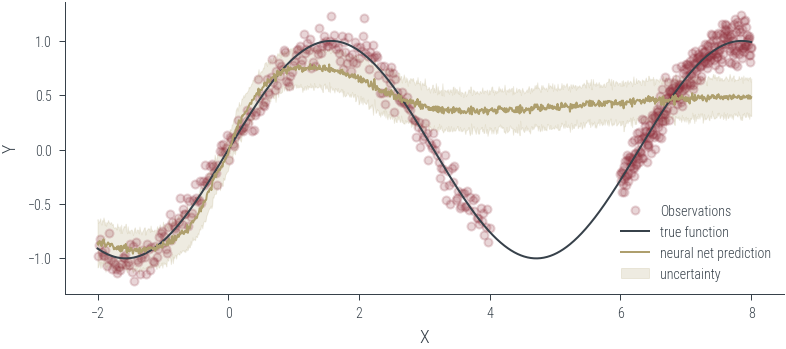

In [36]:
# Plot mean and variance of MC dropout predictions

mean = preds.mean(axis=0)
std = preds.std(axis=0)

def plot_predictions_with_uncertainty(x_test, y_preds, y_std):
    def add_predictions(ax):
        ax.plot(x_test, y_preds, 'C2', label='neural net prediction')
        ax.fill_between(x_test.ravel(), y_preds - y_std, y_preds + y_std, alpha=0.2, color='C2', label='uncertainty')

    plot_generic(add_predictions)

plot_predictions_with_uncertainty(test_x.cpu(), mean, std)


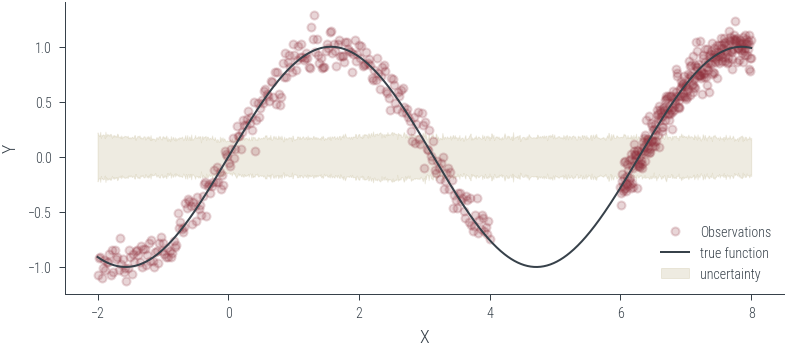

In [37]:
# Just plot the uncertainty

def plot_uncertainty(x_test, y_std):
    def add_predictions(ax):
        ax.fill_between(x_test.ravel(), -y_std, y_std, alpha=0.2, color='C2', label='uncertainty')

    plot_generic(add_predictions)
    
plot_uncertainty(test_x.cpu(), std)

## MLP with residual connections

> We need to have same number of neurons in all layers to form a residual connection.

In [38]:
# Define a simple MLP without using nn.Linear

input_dim = 1

hidden_l1_dim = 50
hidden_l2_dim = 50


def init_params():
    W1 = nn.Parameter(torch.randn(input_dim, hidden_l1_dim, requires_grad=True).to(device))
    b1 = nn.Parameter(torch.zeros(hidden_l1_dim, requires_grad=True).to(device))
    W2 = nn.Parameter(torch.randn(hidden_l1_dim, hidden_l2_dim, requires_grad=True).to(device))
    b2 = nn.Parameter(torch.zeros(hidden_l2_dim, requires_grad=True).to(device))
    W3 = nn.Parameter(torch.randn(hidden_l2_dim, 1, requires_grad=True).to(device))
    b3 = nn.Parameter(torch.zeros(1, requires_grad=True).to(device))
    return [W1, b1, W2, b2, W3, b3]


def mlp(x, params, p=0.0):
    W1, b1, W2, b2, W3, b3 = params
    h1 = torch.tanh(x @ W1 + b1)
    h2 = torch.tanh(h1 @ W2 + b2)
    # residual connection
    h2 = h2 + h1
    return (h2 @ W3 + b3).ravel()

In [39]:
parameters = init_params()

# Continue with optimizer
optimizer = torch.optim.Adam(parameters, lr=3e-4)

trained_params = train(parameters, optimizer, mlp, train_x, train_y, epochs=6000, dropout=False, p=0.0)

Epoch 0, loss 5.608
Epoch 300, loss 0.153
Epoch 600, loss 0.050
Epoch 900, loss 0.030
Epoch 1200, loss 0.018
Epoch 1500, loss 0.016
Epoch 1800, loss 0.015
Epoch 2100, loss 0.014
Epoch 2400, loss 0.014
Epoch 2700, loss 0.013
Epoch 3000, loss 0.013
Epoch 3300, loss 0.013
Epoch 3600, loss 0.012
Epoch 3900, loss 0.012
Epoch 4200, loss 0.011
Epoch 4500, loss 0.010
Epoch 4800, loss 0.010
Epoch 5100, loss 0.010
Epoch 5400, loss 0.010
Epoch 5700, loss 0.009


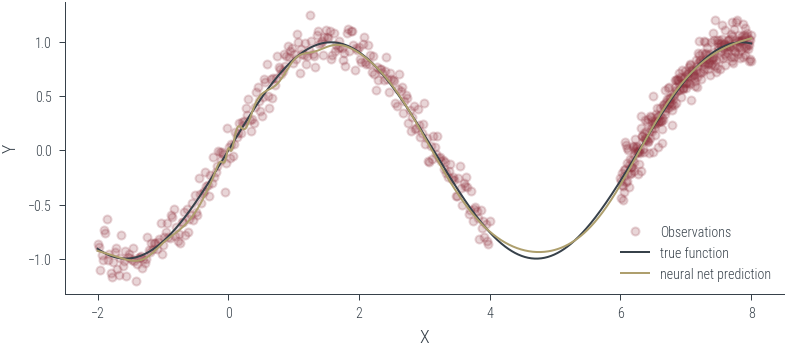

In [40]:
# Plot the trained model
with torch.no_grad():
    y_hat_trained = mlp(test_x, trained_params).ravel()
# Detach and convert to numpy
y_hat_trained = y_hat_trained.cpu().detach().numpy()

plot_predictions(test_x.cpu(), y_hat_trained)

## Deep ensemble with residual connections

In [41]:
n_ensembles = 5

ensemble_params_list = []
for i in range(n_ensembles):
    print(f"Training ensemble member {i}")
    parameters = init_params()
    optimizer = torch.optim.Adam(parameters, lr=3e-4)
    trained_params = train(parameters, optimizer, mlp, train_x, train_y, epochs=6000, dropout=False, p=0.0)
    ensemble_params_list.append(trained_params)

Training ensemble member 0
Epoch 0, loss 2.491
Epoch 300, loss 0.038
Epoch 600, loss 0.018
Epoch 900, loss 0.015
Epoch 1200, loss 0.015
Epoch 1500, loss 0.014
Epoch 1800, loss 0.014
Epoch 2100, loss 0.013
Epoch 2400, loss 0.013
Epoch 2700, loss 0.013
Epoch 3000, loss 0.013
Epoch 3300, loss 0.012
Epoch 3600, loss 0.012
Epoch 3900, loss 0.012
Epoch 4200, loss 0.011
Epoch 4500, loss 0.011
Epoch 4800, loss 0.010
Epoch 5100, loss 0.010
Epoch 5400, loss 0.010
Epoch 5700, loss 0.010
Training ensemble member 1
Epoch 0, loss 1.597
Epoch 300, loss 0.038
Epoch 600, loss 0.020
Epoch 900, loss 0.017
Epoch 1200, loss 0.016
Epoch 1500, loss 0.015
Epoch 1800, loss 0.015
Epoch 2100, loss 0.014
Epoch 2400, loss 0.014
Epoch 2700, loss 0.013
Epoch 3000, loss 0.013
Epoch 3300, loss 0.012
Epoch 3600, loss 0.011
Epoch 3900, loss 0.011
Epoch 4200, loss 0.010
Epoch 4500, loss 0.010
Epoch 4800, loss 0.009
Epoch 5100, loss 0.009
Epoch 5400, loss 0.009
Epoch 5700, loss 0.009
Training ensemble member 2
Epoch 0, lo

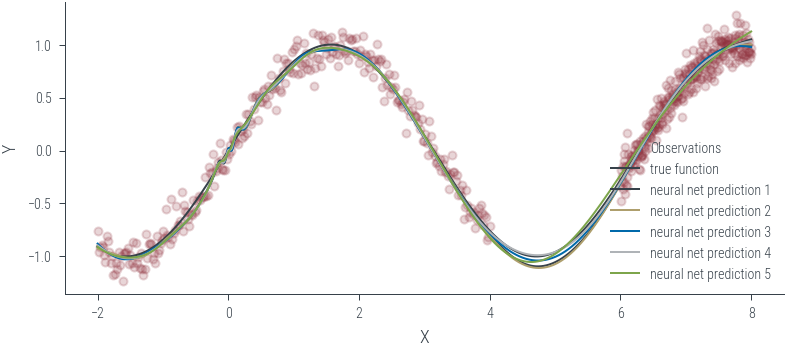

In [42]:
y_preds_list = []
for trained_params in ensemble_params_list:
    with torch.no_grad():
        y_hat_trained = mlp(test_x, trained_params)
        y_hat_trained = y_hat_trained.cpu().numpy()
        y_preds_list.append(y_hat_trained)
        
plot_deep_ensemble(test_x.cpu(), y_preds_list)

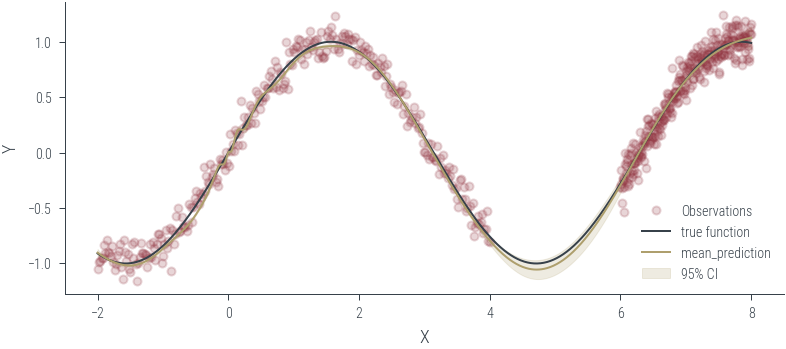

In [43]:
plot_deep_ensemble_uncertainty(test_x.cpu(), y_preds_list)

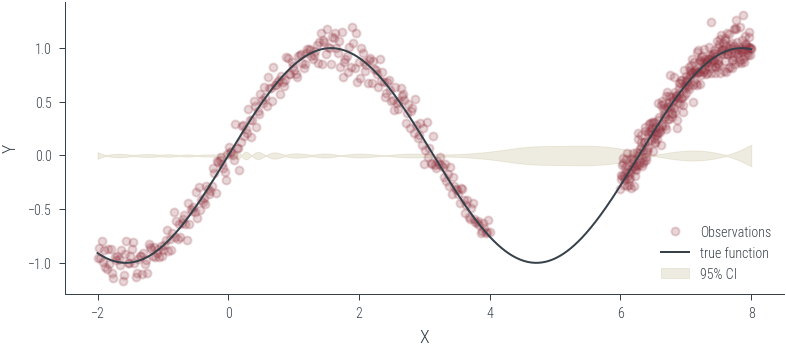

In [44]:
plot_just_uncertainty_deep_ensemble(test_x.cpu(), y_preds_list)

## MC-dropout with residual connections

In [45]:
### Rewriting the model with dropout

input_dim = 1

hidden_l1_dim = 30
hidden_l2_dim = 30

def init_params():
    W1 = nn.Parameter(torch.randn(input_dim, hidden_l1_dim, requires_grad=True).to(device))
    b1 = nn.Parameter(torch.zeros(hidden_l1_dim, requires_grad=True).to(device))
    W2 = nn.Parameter(torch.randn(hidden_l1_dim, hidden_l2_dim, requires_grad=True).to(device))
    b2 = nn.Parameter(torch.zeros(hidden_l2_dim, requires_grad=True).to(device))
    W3 = nn.Parameter(torch.randn(hidden_l2_dim, 1, requires_grad=True).to(device))
    b3 = nn.Parameter(torch.zeros(1, requires_grad=True).to(device))
    return [W1, b1, W2, b2, W3, b3]

def mlp_dropout(x, params, p=0.0, training=True):
    W1, b1, W2, b2, W3, b3 = params
    h1 = torch.tanh(x @ W1 + b1)
    #####################
    # We don't want to apply dropout to the input layer
    #####################
    # if training:
        # probability of dropping out each neuron
        # mask = torch.rand_like(h1) > p
        # h1 = h1 * mask
        # scale activations to account for dropout
        #h1 = h1 / (1 - p)
    h2 = torch.tanh(h1 @ W2 + b2)
    if training:
        # probability of dropping out each neuron
        mask = torch.rand_like(h2) > p
        h2 = h2 * mask
        # scale activations to account for dropout
        h2 = h2 / (1 - p)
    # add residual connection
    h2 = h2 + h1
    h3 = h2 @ W3 + b3
    return h3.ravel()

In [46]:
# Train the model
p = 0.5
parameters = init_params()

# Continue with optimizer
optimizer = torch.optim.Adam(parameters, lr=1e-3)
trained_params = train(parameters, optimizer, mlp_dropout, train_x, train_y, epochs=6000, dropout=True, p=p)

Epoch 0, loss 35.309
Epoch 300, loss 3.127
Epoch 600, loss 0.516
Epoch 900, loss 0.224
Epoch 1200, loss 0.117
Epoch 1500, loss 0.100
Epoch 1800, loss 0.080
Epoch 2100, loss 0.062
Epoch 2400, loss 0.053
Epoch 2700, loss 0.049
Epoch 3000, loss 0.047
Epoch 3300, loss 0.047
Epoch 3600, loss 0.039
Epoch 3900, loss 0.037
Epoch 4200, loss 0.034
Epoch 4500, loss 0.039
Epoch 4800, loss 0.035
Epoch 5100, loss 0.033
Epoch 5400, loss 0.033
Epoch 5700, loss 0.039


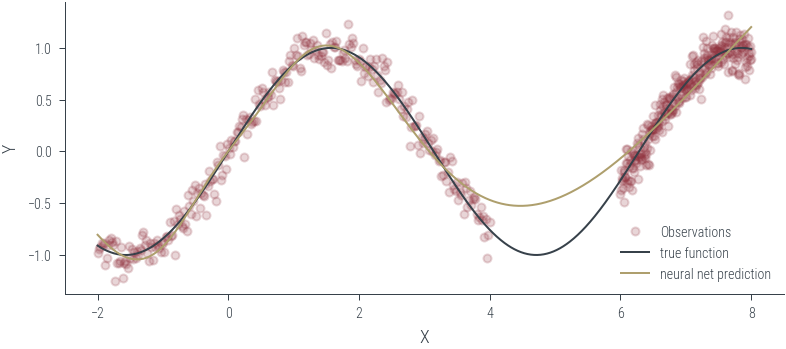

In [47]:
# Predictions with dropout
with torch.no_grad():
    y_hat_dropout = mlp_dropout(test_x, trained_params, training=False).ravel()

# Detach and convert to numpy
y_hat_dropout = y_hat_dropout.cpu().detach().numpy()

plot_predictions(test_x.cpu(), y_hat_dropout)

In [48]:
# Get the predictions for the test set with dropout set to True

preds = []
for i in range(100):
    with torch.no_grad():
        y_hat_dropout = mlp_dropout(test_x, trained_params, training=True, p=p).ravel()
    # Detach and convert to numpy
    y_hat_dropout = y_hat_dropout.cpu().detach().numpy()
    preds.append(y_hat_dropout)

preds = np.array(preds)
preds.shape

(100, 1000)

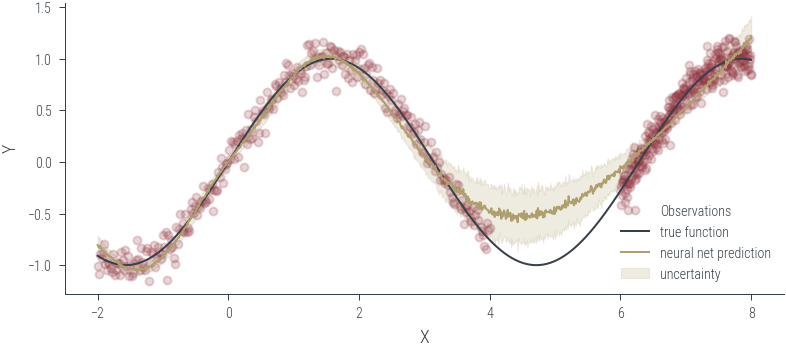

In [49]:
# Plot mean and variance of MC dropout predictions

mean = preds.mean(axis=0)
std = preds.std(axis=0)

def plot_predictions_with_uncertainty(x_test, y_preds, y_std):
    def add_predictions(ax):
        ax.plot(x_test, y_preds, 'C2', label='neural net prediction')
        ax.fill_between(x_test.ravel(), y_preds - y_std, y_preds + y_std, alpha=0.2, color='C2', label='uncertainty')

    plot_generic(add_predictions)

plot_predictions_with_uncertainty(test_x.cpu(), mean, std)

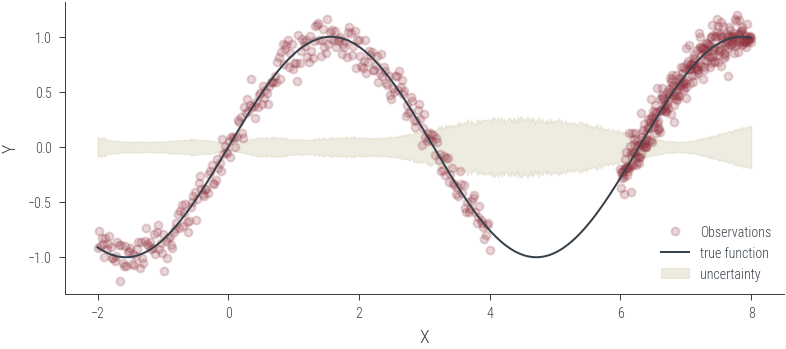

In [50]:
# Just plot the uncertainty

def plot_uncertainty(x_test, y_std):
    def add_predictions(ax):
        ax.fill_between(x_test.ravel(), -y_std, y_std, alpha=0.2, color='C2', label='uncertainty')

    plot_generic(add_predictions)
    
plot_uncertainty(test_x.cpu(), std)